# Notebook overview

This notebook is a proof of concept of a non supervised classification of the products based the image processing techniques.

The goal of this part of the project is to demonstrate the possibility to assign a category to each product automatically based on its image

The POC includes the following parts:
1. Import and process dataset
2. Quick exploratory analysis
3. Images preprocessing
4. Feature extraction using different techniques (ORB, SIFT, CNN)
5. Dimensionality reduction, graphic analysis and clustering


# Imports
## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import time, os, random, math, importlib
from os import listdir
import utils
importlib.reload(utils)

# sklearn
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn import preprocessing
from skimage import io, exposure

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

# OpenCV
import cv2

# keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import vgg16, resnet50

# settings
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('whitegrid', {'grid.linewidth': .05, 'grid.color': '.85'})
sns.set_palette('Set2')

## Data

The data represents a sample extract from the Flipkart product catalogue and does not have any intellectual property issues.

In [2]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                                                                              product_url  \
0     http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1              http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2     http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3     http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...   
4     http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...   
...                                                                                                   ...   
1045  http://www.flipkart.com/oren-empower-extra-large-self-adhesive-sticker/p/itme88zgzgcvtbpx?pid=ST...   
1046       http://www.flipkart.com/wallmantra-large-vinyl-sticker/p/itmec889fxheshyg?pid=STIEC889ZD5GDCVQ   
1047  http://www.flipkart.com/uberlyfe-extra-large-pigmented-polyvinyl-films-imported-sticker/p/itme5u...   
1048      http://www.flipkart.com/wallmantra-medium-vinyl-sticker/p/itmec889gxdsfhzb?pid=STIEC889ZGFD3RCE   
1049         http://www.flipkart.com/uberlyfe-large-vinyl-sticker/p/itme2zepqqzr9jt5?pid=STIE2ZEPACRQJKH7   

                                                           product_name  \
0            Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                            Sathiyas Cotton Bath Towel   
2                                   Eurospa Cotton Terry Face Towel Set   
3       SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4                 Jaipur Print Cotton Floral King sized Double Bedsheet   
...                                                                 ...   
1045                     Oren Empower Extra Large Self Adhesive Sticker   
1046                             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker   
1048                            Wallmantra Medium Vinyl Sticker Sticker   
1049                                       Uberlyfe Large Vinyl Sticker   

                                                                                    product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   
...                                                                                                   ...   
1045                              ["Baby Care >> Baby & Kids Gifts >> Stickers >> Oren Empower Stickers"]   
1046                                ["Baby Care >> Baby & Kids Gifts >> Stickers >> Wallmantra Stickers"]   
1047       

# Preprocessing

In this part of the project, we'll perform a category extraction from the category tree field and encode it with LabelEncoder for further use. As we already did a quick analysis on categories in the NLP part, we won't repeat it here.

## Extract category

In [3]:
df['category'] = df['product_category_tree'].apply(lambda x: utils.extract_category(x, 0))
df.sample(10)

uniq_id            crawl_timestamp  \
335   353ddb2c8ab6920d8ad1055abee87dda  2015-12-01 06:13:00 +0000   
1029  90906358dac904c4f05c12c798ac5221  2016-03-03 06:06:42 +0000   
81    4e130ed339dcfe20d2c8b66892278a94  2016-03-10 07:45:58 +0000   
1004  6325bf868b9040a0599f257aba42e9e0  2016-03-03 11:29:08 +0000   
426   70461caa9038cfa34d109ea056d57f5a  2016-04-25 19:45:35 +0000   
271   9906d8f74589c452b00f2b5642a63c5f  2015-12-01 12:40:44 +0000   
352   833a87b0af3b84fe246d2ebf271af177  2015-12-01 06:13:00 +0000   
283   4d2e9f36823bad0f6fe8c6b19bb92bdb  2016-04-24 18:34:50 +0000   
179   aab46b84f70cc6774afaafe1d6035de3  2015-12-01 12:40:44 +0000   
689   55195de3873fffaa9e37b041533d7305  2015-12-31 09:19:31 +0000   

                                                                                              product_url  \
335                              http://www.flipkart.com/tenda-a5/p/itmdp2cxeq633zhd?pid=RTRDNY65WHG9FHTS   
1029  http://www.flipkart.com/aroma-comfort-polyester-brown-printed-eyelet-window-curtain/p/itmeg8d7am...   
81               http://www.flipkart.com/treasure-showpiece-23-cm/p/itmeghnc7cm8zdu4?pid=SHIEGHNCZBRTKZCR   
1004  http://www.flipkart.com/doraemon-gift-family-ceramic-coffee-mug-multicolour-325-ml/p/itmeg7k7fe4...   
426     http://www.flipkart.com/basra-uepgrn-green-changing-table/p/itmehetvtpgfphzx?pid=DSEEHETVWRX9FZDT   
271       http://www.flipkart.com/s-c-handicrafts-showpiece-40-cm/p/itme2qtscjuwxgmt?pid=SHIE2QTSMSXF9QAH   
352                        http://www.flipkart.com/zyxel-pla-4205/p/itmdyzydwztvmdf8?pid=RTRDYZYDXGHXXJNZ   
283   http://www.flipkart.com/yves-bertelin-ybscr557-analog-watch-women/p/itmehyhj8ah7fxnm?pid=WATEHYH...   
179   http://www.flipkart.com/rockmantra-beautiful-girl-big-feather-hat-ceramic-mug/p/itmeaggkykbf2qge...   
689   http://www.flipkart.com/philips-9-5-w-led-b22-3000k-a55-ind-bulb/p/itmef3hhfzfzf2vn?pid=BLBEF3HE...   

                                                          product_name  \
335                                                           Tenda A5   
1029       Aroma Comfort Polyester Brown Printed Eyelet Window Curtain   
81                                        Treasure Showpiece  -  23 cm   
1004  Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml   
426                                  BASRA uepgrn Green Changing Table   
271                                S C Handicrafts Showpiece  -  40 cm   
352                                                     Zyxel PLA-4205   
283                   Yves Bertelin YBSCR557 Analog Watch  - For Women   
179         Rockmantra Beautiful Girl With Big Feather Hat Ceramic Mug   
689                           Philips 9.5 W LED B22 3000K A55 IND Bulb   

                                                                                    product_category_tree  \
335                                       ["Computers >> Network Components >> Routers >> Tenda Routers"]   
1029  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Aroma Comfort Polyester Brown Printed...   
81    ["Home Decor & Festive Needs >> Table Decor & Handicrafts >> Showpieces >> Fengshui >> Treasure ...   
1004  ["Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decor...   
426   ["Baby Care >> Diapering & Potty Training >> Changing Tables >> BASRA Changing Tables >> BASRA u...   
271                            ["Home Decor & Festive Needs >> Showpieces >> S C Handicrafts Showpieces"]   
352                                       ["Computers >> Network Components >> Routers >> Zyxel Routers"]   
283   ["Watches >> Wrist Watches >> Yves Bertelin Wrist Watches >> Yves Bertelin YBSCR557 Analog Watch...   
179                                         ["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]   
689                                            ["Kitchen & Dining >> Lighting >> Bulbs >> Philips Bulbs"]   

                   pid  retail_price  discounted_price  

Use LabelEncoder to encode the category

In [4]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                                                                              product_url  \
0     http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1              http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2     http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3     http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...   
4     http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...   
...                                                                                                   ...   
1045  http://www.flipkart.com/oren-empower-extra-large-self-adhesive-sticker/p/itme88zgzgcvtbpx?pid=ST...   
1046       http://www.flipkart.com/wallmantra-large-vinyl-sticker/p/itmec889fxheshyg?pid=STIEC889ZD5GDCVQ   
1047  http://www.flipkart.com/uberlyfe-extra-large-pigmented-polyvinyl-films-imported-sticker/p/itme5u...   
1048      http://www.flipkart.com/wallmantra-medium-vinyl-sticker/p/itmec889gxdsfhzb?pid=STIEC889ZGFD3RCE   
1049         http://www.flipkart.com/uberlyfe-large-vinyl-sticker/p/itme2zepqqzr9jt5?pid=STIE2ZEPACRQJKH7   

                                                           product_name  \
0            Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                            Sathiyas Cotton Bath Towel   
2                                   Eurospa Cotton Terry Face Towel Set   
3       SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4                 Jaipur Print Cotton Floral King sized Double Bedsheet   
...                                                                 ...   
1045                     Oren Empower Extra Large Self Adhesive Sticker   
1046                             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker   
1048                            Wallmantra Medium Vinyl Sticker Sticker   
1049                                       Uberlyfe Large Vinyl Sticker   

                                                                                    product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   
...                                                                                                   ...   
1045                              ["Baby Care >> Baby & Kids Gifts >> Stickers >> Oren Empower Stickers"]   
1046                                ["Baby Care >> Baby & Kids Gifts >> Stickers >> Wallmantra Stickers"]   
1047       

## Clean

Keep only relevant fields

In [5]:
data = df.copy()
data = data[['image', 'category', 'label']]
data.head(5)

image         category  label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing      4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care      0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care      0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing      4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing      4

In [6]:
categories = data['category'].unique()
categories

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [7]:
data.groupby('category').count()

image  label
category                                
Baby Care                     150    150
Beauty and Personal Care      150    150
Computers                     150    150
Home Decor & Festive Needs    150    150
Home Furnishing               150    150
Kitchen & Dining              150    150
Watches                       150    150

## Extract image

We will be loading images from the provided folder:

In [8]:
images_path = "Flipkart/Images"

images_list = [f for f in os.listdir(images_path) if not f.startswith('.')]

print(len(images_list))
print(images_list[:10])

1050
['aa68675f50a0551b8dadb954017a50a1.jpg', '037c2402fee39fbc80433935711d1383.jpg', '42643c1c9403f67921a18654bcf45ead.jpg', '53f4bc7d7321f5c41de6b86e41f13e80.jpg', 'b144a363c107c7bdd91f32d6e28ba6f2.jpg', 'db3e2eeb4fe90d4755f2911d661eae95.jpg', '9a9402ad55d079c86c302521816b7b0e.jpg', '42a8fef62716772c391fbdd148cc9c16.jpg', '503bb08f7bdf6a395ec564dd1dc83619.jpg', '42770faa04bfcf2b62e7ef335e1b1965.jpg']


We get 1050 files that equals to our dataset length, let's check however if there are no errors and every product in the dataset has a corresponding image in the images folder

In [9]:
images_list_in_df = list(data['image'])
images_list_in_df[:10]

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 '64d5d4a258243731dc7bbb1eef49ad74.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg',
 '893aa5ed55f7cff2eccea7758d7a86bd.jpg',
 'f355cc1ccb08bd0d283ed979b7ee7515.jpg',
 'dd0e3470a7e6ed76fd69c2da27721041.jpg',
 '41384da51732c0b4df3de8f395714fbb.jpg',
 '710ed5f2393a4b9e8823aa0029f71f93.jpg']

Check if all the images present in the image folder correspond to the image name in the dataset.

In [10]:
images_list.sort()
images_list_in_df.sort()

images_list == images_list_in_df

True

So we have all corresponding images to the products in the dataset.

### Test skimage vs OpenCV image extraction


There are different tools to read the image, we will be using OpenCV to do the feature extraction and descriptors detection so we will proceed with cv2 tools. However it will be interesting to compare the other libraries like skimage to see if there are major differencies.

In [11]:
# Test on 1 image
test_image = data['image'][0]
test_image_path = images_path + '/' + test_image

**OpenCV**

In [12]:
img_cv2 = cv2.imread(test_image_path)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
print(img_cv2.shape)
img_cv2

(3600, 3600, 3)


array([[[192, 184, 173],
        [192, 184, 173],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 184, 173],
        [193, 185, 174],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 186, 174],
        [193, 187, 175],
        [193, 187, 175],
        ...,
        [175, 166, 157],
        [174, 165, 156],
        [174, 165, 156]],

       ...,

       [[209, 174, 136],
        [209, 174, 136],
        [209, 174, 136],
        ...,
        [130,  94,  96],
        [134,  99,  97],
        [139, 104, 100]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [140, 105, 103],
        [143, 108, 102],
        [147, 113, 104]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [149, 114, 110],
        [151, 117, 108],
        [154, 120, 110]]

A NumPy array is produced after reading an image file with the cv2.imread() method. By default, the image is saved in the BGR color space. While BGR is used consistently throughout OpenCV, most other image processing libraries use the RGB ordering, therefore we need to transform it to the RGB format if we want to display it with matplotlib.

Convert to gray scale

In [13]:
img_cv2_gray = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
print(img_cv2_gray.shape)
img_cv2_gray

(3600, 3600)


array([[185, 185, 186, ..., 167, 167, 167],
       [185, 186, 186, ..., 167, 167, 167],
       [186, 187, 187, ..., 168, 167, 167],
       ...,
       [180, 180, 180, ..., 105, 109, 114],
       [181, 181, 181, ..., 115, 118, 122],
       [181, 181, 181, ..., 124, 126, 129]], dtype=uint8)

**Skimage**

In [14]:
img_io = io.imread(test_image_path)
print(img_io.shape)
img_io

(3600, 3600, 3)


array([[[192, 184, 173],
        [192, 184, 173],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 184, 173],
        [193, 185, 174],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 186, 174],
        [193, 187, 175],
        [193, 187, 175],
        ...,
        [175, 166, 157],
        [174, 165, 156],
        [174, 165, 156]],

       ...,

       [[209, 174, 136],
        [209, 174, 136],
        [209, 174, 136],
        ...,
        [130,  94,  96],
        [134,  99,  97],
        [139, 104, 100]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [140, 105, 103],
        [143, 108, 102],
        [147, 113, 104]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [149, 114, 110],
        [151, 117, 108],
        [154, 120, 110]]

In [15]:
img_io_gray = io.imread(test_image_path, True)
print(img_io_gray.shape)
img_io_gray

(3600, 3600)


array([[0.7251251 , 0.7251251 , 0.72904667, ..., 0.65201412, 0.65201412,
        0.65201412],
       [0.7251251 , 0.72904667, 0.72904667, ..., 0.65201412, 0.65201412,
        0.65201412],
       [0.73101882, 0.73494039, 0.73494039, ..., 0.65593569, 0.65201412,
        0.65201412],
       ...,
       [0.70077529, 0.70077529, 0.70077529, ..., 0.39919294, 0.41683647,
        0.43587882],
       [0.70469686, 0.70469686, 0.70469686, ..., 0.44036588, 0.45099961,
        0.46892588],
       [0.70469686, 0.70469686, 0.70469686, ..., 0.47509451, 0.48461216,
        0.49609412]])

**Compare**

In [16]:
print(f'min value cv2: {img_cv2_gray.min()}, max_value: {img_cv2_gray.max()}')

min value cv2: 0, max_value: 255


In [17]:
print(f'min value io: {img_io_gray.min()}, max_value: {img_io_gray.max()}')

min value io: 0.0, max_value: 1.0


Both methods reshaped the image matrix from (lx, ly, lz) to (lx, ly). However, the gray scale pixel values don't have the same format, for **cv2** we get values from 0 to 255, for **io** we get 64-bit floats from 0 to 1, let's see if it has an effect on the histogram

(3600, 3600, 3)
(3600, 3600, 3)


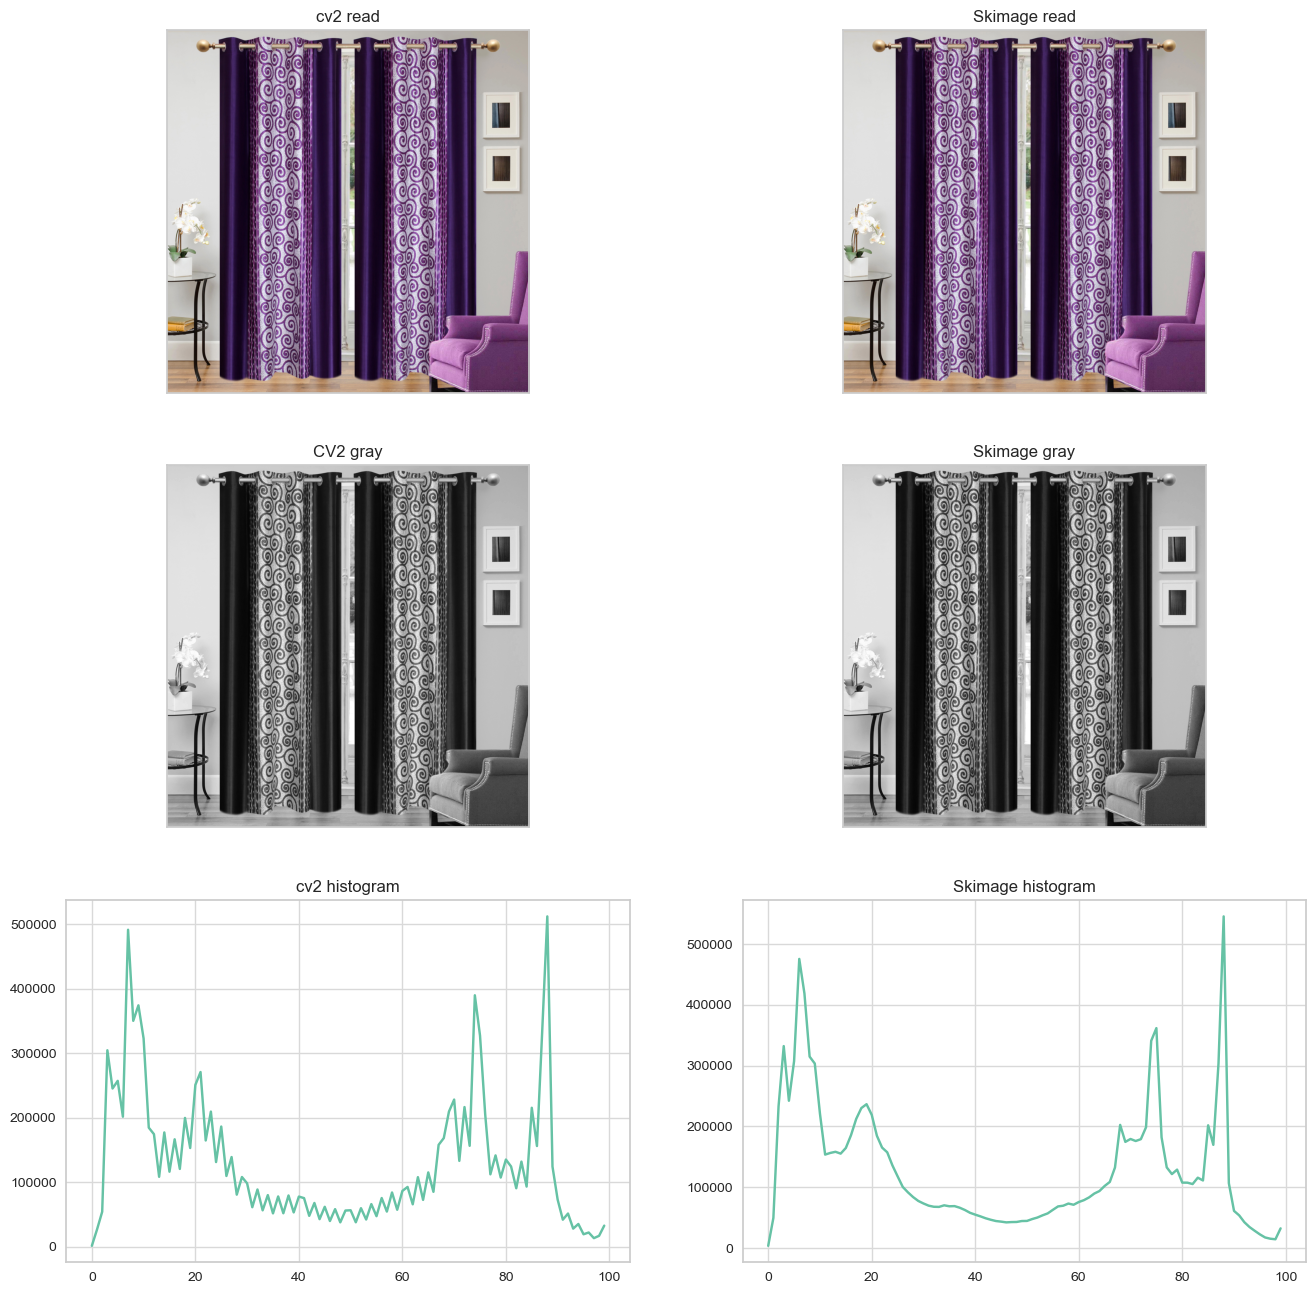

In [18]:
print(img_cv2.shape)
print(img_io.shape)

plt.figure(figsize=(16, 16))

plt.subplot(3, 2, 1)
plt.imshow(img_cv2)
plt.title('cv2 read')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 2)
plt.imshow(img_io)
plt.title('Skimage read')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 3)
plt.imshow(img_cv2_gray, cmap='gray')
plt.title('CV2 gray')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 4)
plt.imshow(img_io_gray, cmap='gray')
plt.title('Skimage gray')
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 5)
h = np.histogram(img_cv2_gray, 100)
plt.plot(h[0])
plt.title('cv2 histogram')

plt.subplot(3, 2, 6)
h = np.histogram(img_io_gray, 100)
plt.plot(h[0])
plt.title('Skimage histogram')

plt.show()


We don't see huge differences in the image rendering for both cv2 and io, in terms of colors, quality, sharpness.

Both histograms have the same global shape, however, the **io** histogram looks smoother than the **cv2** one, it might be due to the different values format used by the libraries.

In conclusion, we will stick with the cv2 methods for the feature extraction.

### Read images

Read images and store the matrices in the dataframe. Use the grayscale to reduce the matrix dimensions to optimize the space.

In [20]:
data['image_raw_gray'] = data['image'].apply(lambda x: cv2.imread(f'{images_path}/{x}', cv2.IMREAD_GRAYSCALE))

In [21]:
data.sample(10)

image                    category  label  \
1017  4748b7ea0e01cffa561f1a7a7a432813.jpg             Home Furnishing      4   
212   de29bf3288345e23b0e25345a3a057fb.jpg  Home Decor & Festive Needs      3   
518   c0a7134d52d4aa3eb5874aef112f809f.jpg                     Watches      6   
1027  362714cbba2f5ae412d2f26bae99a266.jpg             Home Furnishing      4   
719   3dfdf277bccb74532c0387adfed2897d.jpg                   Baby Care      0   
1025  30ad2acaccdd2e1691a61c44079c2b5a.jpg                   Computers      2   
428   dd5d6f0649f40d49791bbd5c00758e2f.jpg                   Baby Care      0   
736   e33795f66b2a42ac56095ae704ab25b6.jpg    Beauty and Personal Care      1   
177   5dbf978ab2cf9d2da6446d3e4595f690.jpg            Kitchen & Dining      5   
262   e1b2b3ad430dd738d958292441b6d046.jpg  Home Decor & Festive Needs      3   

                                                                                           image_raw_gray  
1017  [[183, 182, 181, 182, 182, 182, 183, 185, 182, 181, 181, 181, 182, 183, 184, 185, 185, 185, 184,...  
212   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
518   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
1027  [[114, 114, 114, 114, 114, 113, 113, 113, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113,...  
719   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
1025  [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
428   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
736   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
177   [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...  
262   [[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,...

In [22]:
samples = data.sample(20)

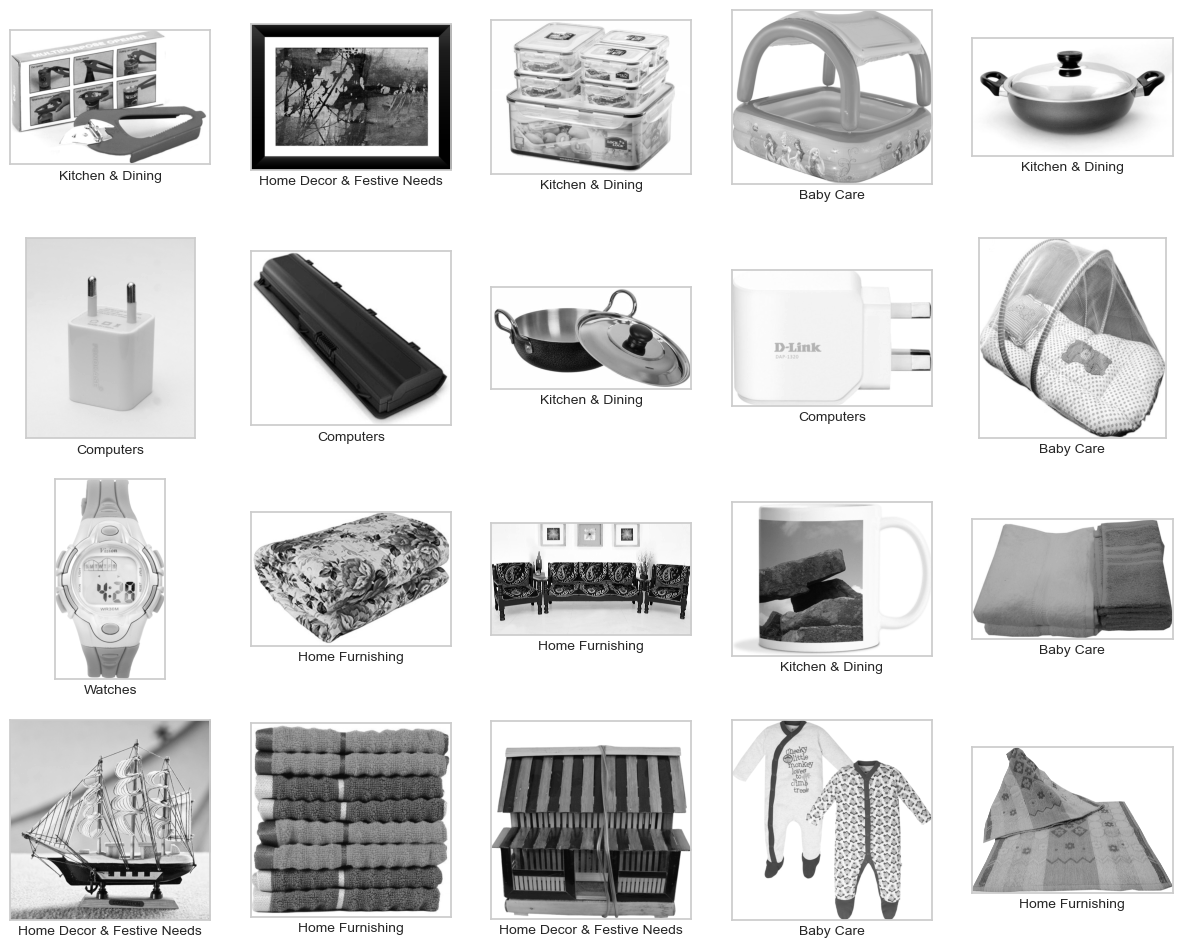

In [23]:
utils.display_images(X=list(samples['image_raw_gray']), y=list(samples['category']),  columns=5, x_size=2, y_size=2)

### Test image transformations

**Contrast and brightness**

In [47]:
random_image = data.sample(1)['image_raw_gray'].to_list()[0]
random_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

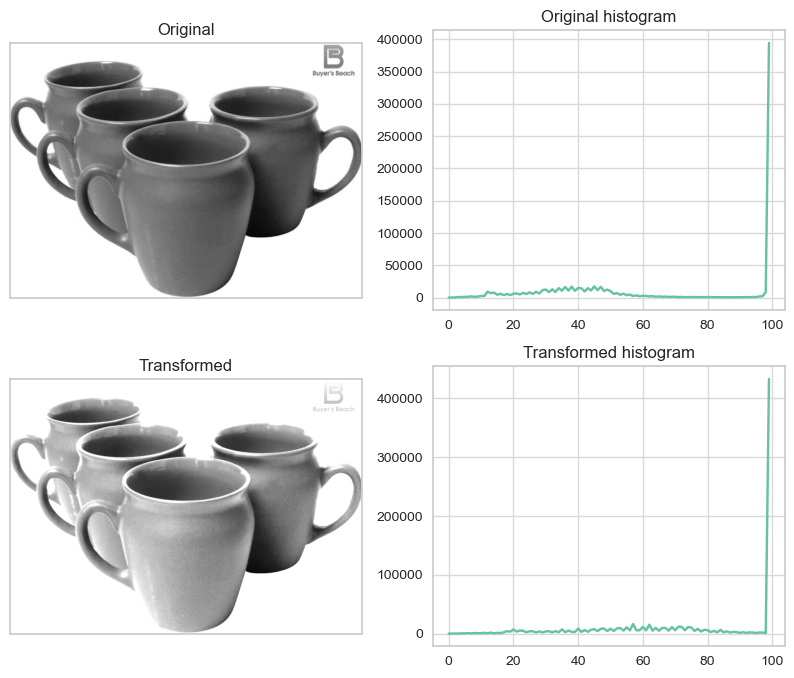

In [49]:
# define the alpha and beta
alpha = 1.5 # Contrast control
beta = 10 # Brightness control

transformed_image = cv2.convertScaleAbs(random_image, alpha=alpha, beta=beta)

# display the output image
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(random_image, cmap='gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
h = np.histogram(random_image, 100)
plt.plot(h[0])
plt.title('Original histogram')

plt.subplot(2, 2, 3)
plt.imshow(transformed_image, cmap='gray')
plt.title('Transformed')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 4)
h = np.histogram(transformed_image, 100)
plt.plot(h[0])
plt.title('Transformed histogram')

plt.show()


**Blurring**

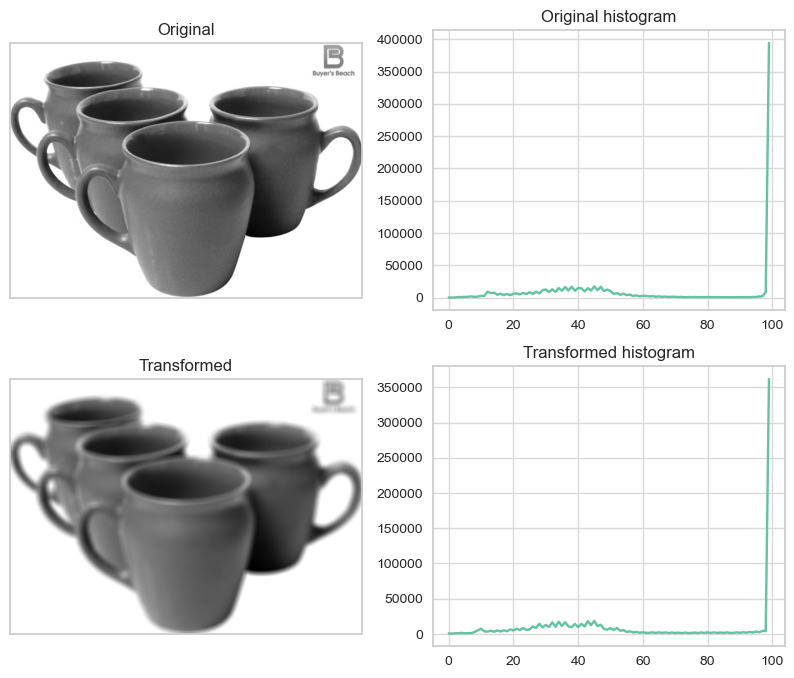

In [53]:
blurred_image = cv2.blur(random_image, (20, 20))

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(random_image, cmap='gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
h = np.histogram(random_image, 100)
plt.plot(h[0])
plt.title('Original histogram')

plt.subplot(2, 2, 3)
plt.imshow(blurred_image, cmap='gray')
plt.title('Transformed')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 4)
h = np.histogram(blurred_image, 100)
plt.plot(h[0])
plt.title('Transformed histogram')

plt.show()

# Quick analysis

Let's check if all images have the same size and ratio

## Image sizes

In [25]:
data['width'] = data['image_raw_gray'].apply(lambda x: x.shape[0])
data['height'] = data['image_raw_gray'].apply(lambda x: x.shape[1])
data['size'] = (data['height'] * data['width'] / 1024 ).round()
data['ratio'] = data['width'] / data['height']

In [26]:
data.head(1)

image         category  label  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing      4   

                                                                                                                                          image_raw_gray  \
0  [[185, 185, 186, 186, 186, 185, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 187, 187, 187, 186, 186, 185, 186, 186, 186, 186, 186,...   

   width  height       size  ratio  
0   3600    3600 12656.0000 1.0000

In [27]:
image_data = ['width', 'height', 'size', 'ratio']
data[image_data].describe()

width    height       size     ratio
count  1050.0000 1050.0000  1050.0000 1050.0000
mean   1220.0381 1196.5705  1871.4124    1.2219
std     744.8414  864.0768  3827.3841    0.7153
min     160.0000  145.0000    57.0000    0.2294
25%     844.0000  747.2500   656.2500    0.7673
50%    1100.0000 1100.0000   992.0000    1.0022
75%    1360.0000 1214.2500  1517.5000    1.4772
max   11042.0000 8484.0000 91485.0000    8.5345

------------
width
------------


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


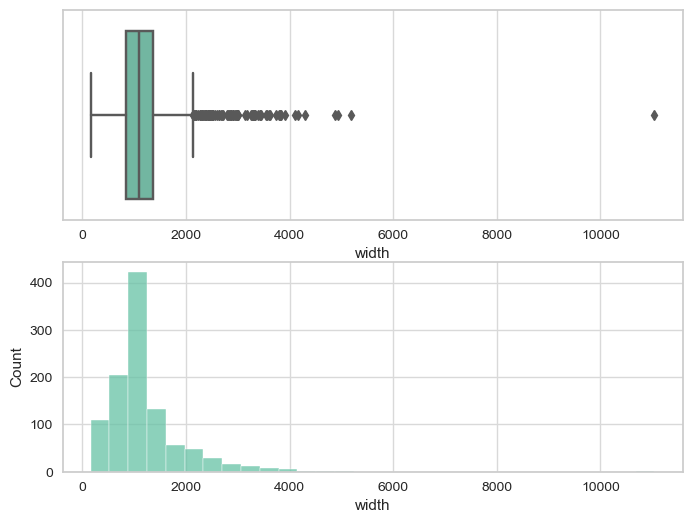

------------
height
------------


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


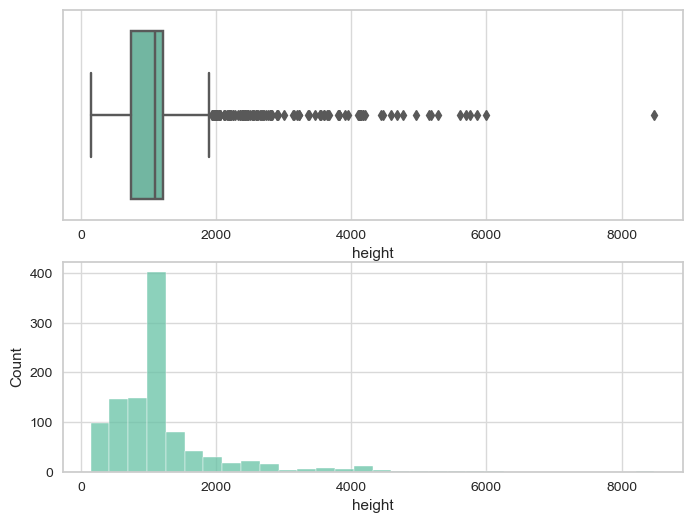

------------
size
------------


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


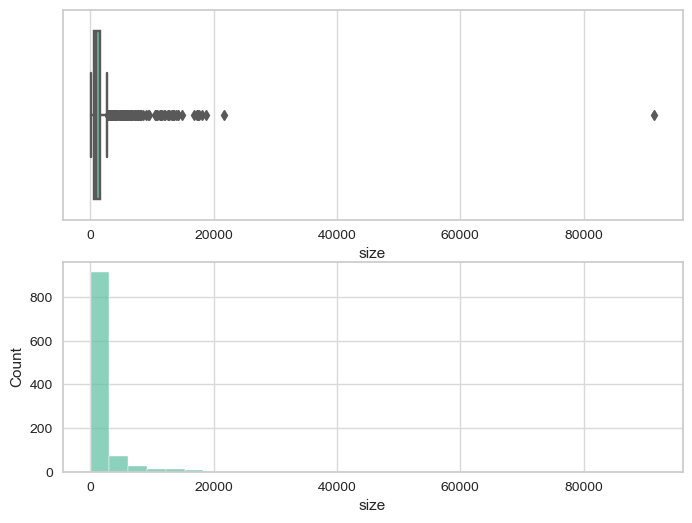

------------
ratio
------------


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


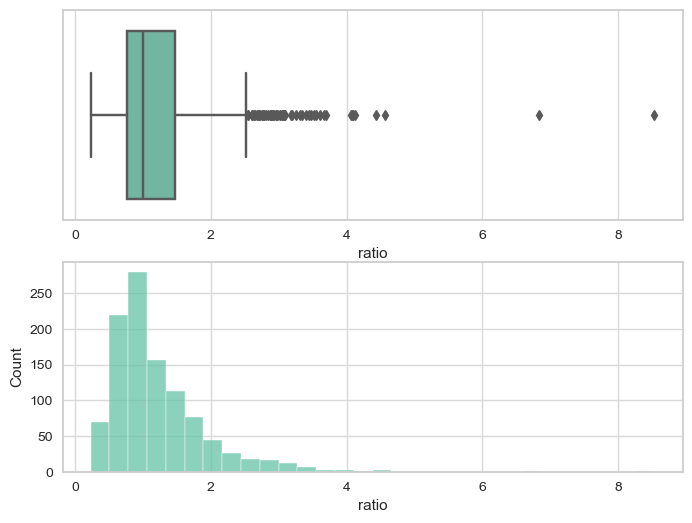

In [28]:
for value in image_data:
    print('------------')
    print(value)
    print('------------')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    sns.boxplot(x=data[value], ax=ax1)
    sns.histplot(data=data, x=value, bins=30, ax=ax2)
    
    plt.show()

Half of the images have a square form (ratio close to 1), we observe however some outliers in landscape layout having a ratio up to 8. This might be an important point to consider for the further image processing like cropping.

# Feature extraction

Feature extraction is an important part of many image processing methods. The ideal feature extraction method would be robust to changes in illumination, rotation, scale, noise and other transformations while being fast enough to be of use in real-time scenarios. 

The extracted local features should be:

- Repeatable
- Distinctive
- Local

We will be exploring 2 methods provided by OpenCV in extracting features:
- ORB
- SIFT

## ORB

Orientated FAST and Robust BRIEF (ORB) is the combination of two algorithms FAST and BRIEF and was created as an alternative to SIFT and SURF in 2011.

FAST or Features from Accelerated Segment Test is used as the key-point detector. It works by selecting pixels in a radius around a key-point candidate and checks if there are n continuous pixels that are all brighter or darker than the candidate pixel. BRIEF or Binary Robust Independent Elementary Features is used as the key-point descriptor. As BRIEF performs poorly with rotation, the computed orientation of the key-points are used to steer the orientation of the key-point patch before extracting the descriptor. Once this is done, a series of binary tests are computed comparing a pattern of pixels in the patch. The output of the binary tests are concatenated and used as the feature descriptor.

**Tests**

Before doing the feature extraction, the images should be converted to black and white and equalized

In [29]:
test_samples = data.sample(4)

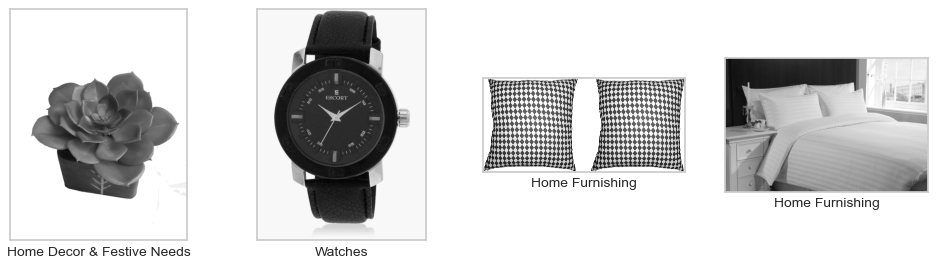

In [30]:
display_images(X=list(test_samples['image_raw_gray']), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)

The next step will be to equalize the histograms of the images, equalization is a method that adjusts the contrast in an image in order to stretch out the intensity range.

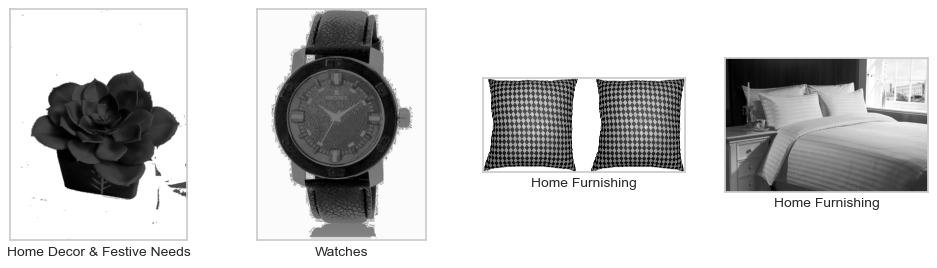

In [31]:
# equalize image histogram
test_images_eq = test_samples['image_raw_gray'].apply(lambda x: cv2.equalizeHist(x))
display_images(X=list(test_images_eq), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)

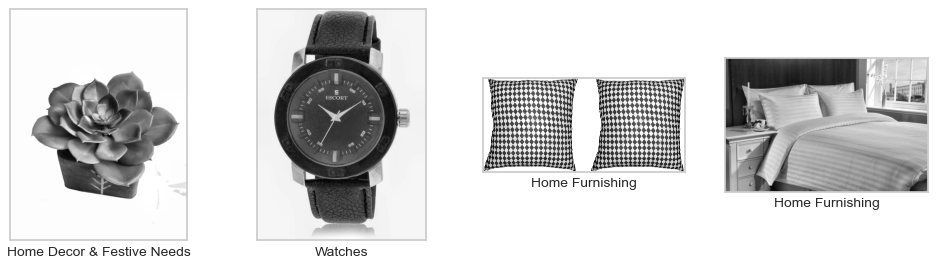

In [32]:
# equalize image histogram using CLAHE (Contrast Limited Adaptive Histogram Equalization)
test_images_clahe = test_samples['image_raw_gray'].apply(lambda x: exposure.equalize_adapthist(x))
display_images(X=list(test_images_clahe), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)

The CLAHE equalizer looks more effective than the ORB's one.

In [33]:
def display_hist_plots(images_list):
    """
    Displays images histograms

    Input:
        images_list: list of images
    Output:
        void
    """
    plt.figure(figsize=(14, 2))
    for image_index in range(len(images_list)):
        plt.subplot(1, len(images_list), image_index + 1)
        h = np.histogram(images_list[image_index], 100)
        plt.plot(h[0])
    plt.show()

Before equalizing

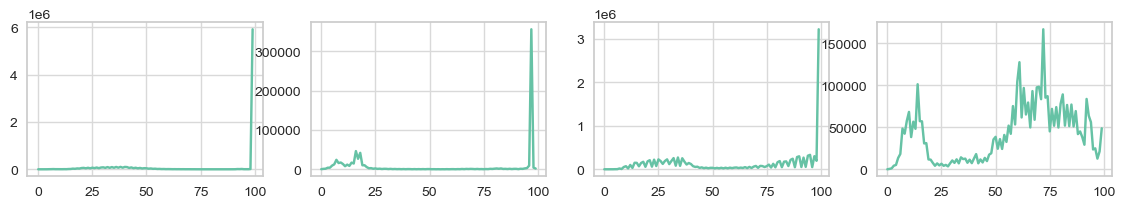

In [34]:
display_hist_plots(list(list(test_samples['image_raw_gray'])))

After ORB equalizing

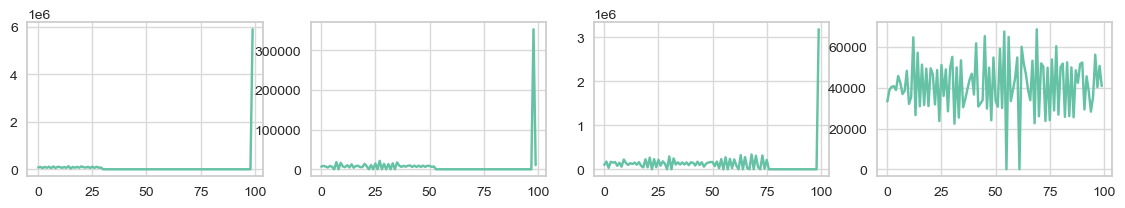

In [35]:
display_hist_plots(list(test_images_eq))

After CLAHE equalizer

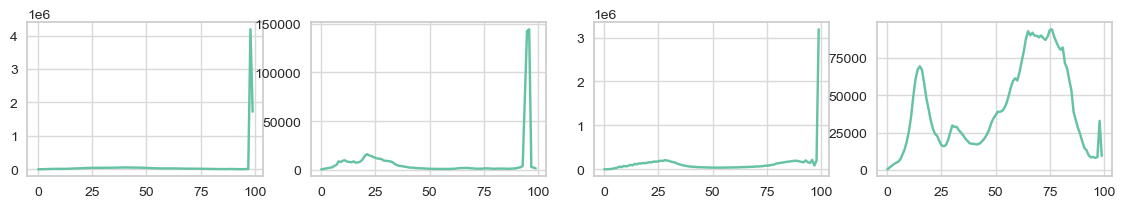

In [36]:
display_hist_plots(list(test_images_clahe))

Display keypoints and descriptors with ORB

In [37]:
orb = cv2.ORB_create()

def get_image_with_keypoints(image, verbose = True):
    """
    Calculate the keypoints for the image
    
    Input:
        image: image matrix

    Output:
        image with keypoints
    """

    keypoints, descriptors = orb.detectAndCompute(image, None)

    if verbose:
        print("Number of Keypoints Detected In The Image: ", len(keypoints))
        print("Number of Descriptors Detected In The Image: ", descriptors.shape)
    
    return cv2.drawKeypoints(image, keypoints, image, color = (0, 255, 0))


In [38]:
print(list(test_samples['image_raw_gray'])[0].shape)
test_images_with_keypoints = test_samples['image_raw_gray'].apply(lambda x: get_image_with_keypoints(x))
list(test_images_with_keypoints)[0].shape

(3305, 2536)
Number of Keypoints Detected In The Image:  500
Number of Descriptors Detected In The Image:  (500, 32)
Number of Keypoints Detected In The Image:  500
Number of Descriptors Detected In The Image:  (500, 32)
Number of Keypoints Detected In The Image:  500
Number of Descriptors Detected In The Image:  (500, 32)
Number of Keypoints Detected In The Image:  500
Number of Descriptors Detected In The Image:  (500, 32)


(3305, 2536, 3)

The keypoints graphics added 2 dimensions to the original image matrix

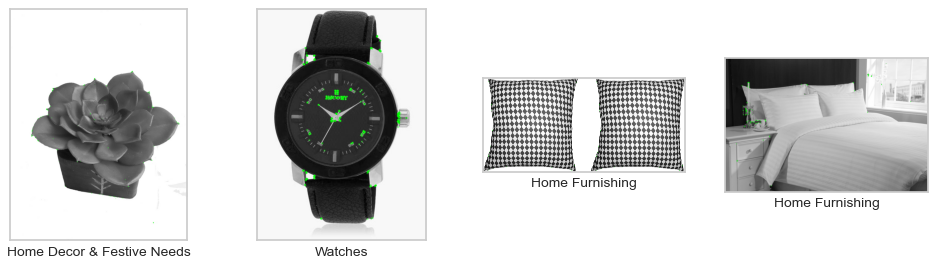

In [39]:
# Without equalizer
display_images(X=list(test_images_with_keypoints), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)

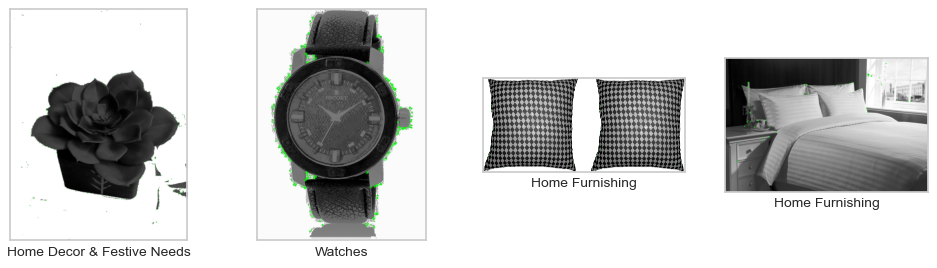

In [109]:
# With cv2 equalizer
test_images_eq_with_keypoints = test_images_eq.apply(lambda x: get_image_with_keypoints(x, verbose=False))
display_images(X=list(test_images_eq_with_keypoints), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)

We notice the most obvious keypoint detection on the second image (watch), where the object outline was almost correctly detected. We can also see that equalization plays a huge role in the keypoint detection.

## Preprocess images

Now we'll apply the above preprocessing techniques to all the images, and will store the descriptors in an array for all the images

In [123]:
start=time.time()

orb_descriptors = []

orb = cv2.ORB_create()

images_raw_gray = list(data['image_raw_gray'])

for image in images_raw_gray :
    # equalize image histogram
    image = cv2.equalizeHist(image)

    # compute keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    orb_descriptors.append(descriptors)

# convert descriptors to array
orb_descriptors_array = np.asarray(orb_descriptors, dtype="object")
orb_descriptors_all = np.concatenate(orb_descriptors_array, axis=0)

print()
print("Number of descriptors : ", orb_descriptors_all.shape)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')


Number of descriptors :  (520145, 32)
execution time: 23.8386 seconds


## Descriptors clustering

We obtained the total number of 520145 descriptors. Each descriptor is unique and specific to each image, contrary to the word tokens where the same word can be encountered in multiple documents. For this reason, we need to group similar descriptors in clusters to make easier the process of finding similarities between images.

We will use `MiniBatchKMeans` clustering that performs the KMeans per batches to improve performance. 

There are different strategies to choose the number of clusters, for example, taking the square root of the number of descriptors, or multiplying by 10 number of true categories, we will explore both techniques.

In [44]:
start = time.time()

# set number of clusters to the squared root of descriptors length
k = int(round(np.sqrt(len(orb_descriptors_all)), 0))
print("Number of estimated clusters : ", k)

# Clustering with batches
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, n_init=10)
kmeans.fit(orb_descriptors_all)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

Number of estimated clusters :  721
execution time: 3.5185 seconds


## Feature creation

Now that we have 721 descriptor clusters, we can calculate the clusters for each image and store them in a vector that represents a histogram of the number of clusters encountered in the given image. This will represent our final features.

In [108]:
def build_histogram(kmeans, descriptors, image_num):
    res = kmeans.predict(descriptors)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(descriptors)
    
    if nb_des == 0 : print("No descriptors for image  : ", image_num)
        
    for i in res:
        hist[i] += 1.0/nb_des
        
    return hist

# test on 1 image descriptors
hist = build_histogram(kmeans, orb_descriptors_array[1], 1) 

hist

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.002,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.004,
       0.002, 0.01 , 0.   , 0.002, 0.   , 0.004, 0.002, 0.002, 0.002,
       0.   , 0.   , 0.002, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.002, 0.002, 0.   , 0.006, 0.002, 0.   , 0.004,
       0.002, 0.002, 0.004, 0.   , 0.008, 0.   , 0.   , 0.   , 0.002,
       0.   , 0.   , 0.   , 0.004, 0.006, 0.002, 0.   , 0.   , 0.004,
       0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.002, 0.002, 0.002,
       0.   , 0.004, 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.002,
       0.   , 0.   , 0.008, 0.002, 0.   , 0.002, 0.006, 0.   , 0.   ,
       0.002, 0.   , 0.002, 0.   , 0.   , 0.002, 0.   , 0.   , 0.002,
       0.012, 0.008, 0.004, 0.   , 0.004, 0.   , 0.006, 0.   , 0.006,
       0.002, 0.002, 0.004, 0.   , 0.   , 0.002, 0.   , 0.   , 0.004,
       0.   , 0.   , 0.002, 0.   , 0.   , 0.008, 0.   , 0.002, 0.   ,
       0.002, 0.   ,

In [113]:
start = time.time()

# Creation of a matrix of histograms
hist_vectors = []

# build the histogram vector for each image from the descriptors array
for i, image_desc in enumerate(orb_descriptors_array) :
    hist = build_histogram(kmeans, image_desc, i) 
    hist_vectors.append(hist)

X_features = np.asarray(hist_vectors)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')


execution time: 0.8516 seconds


In [115]:
X_features.shape

(1050, 721)

We obtained a 721 length vector for each image in the dataset.

# Dimensionality reduction

After the feature extraction step, we will follow the same strategy as the NLP unsupervised classification:

- reducing dimensions with PCA and T-SNE
- perform the visual analysis of the graph with the 2 components obtained by T-SNE
- confirm it with the ARI score after the KMeans clustering
 
## PCA

In [95]:
pca_features = utils.get_pca_reduced_data(X_features)

Dimensions before PCA :  (1050, 721)
Dimensions after PCA :  (1050, 579)


## T-SNE

In [96]:
df_tsne = utils.get_tsne_reduced_dataframe(pca_features)
df_tsne.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

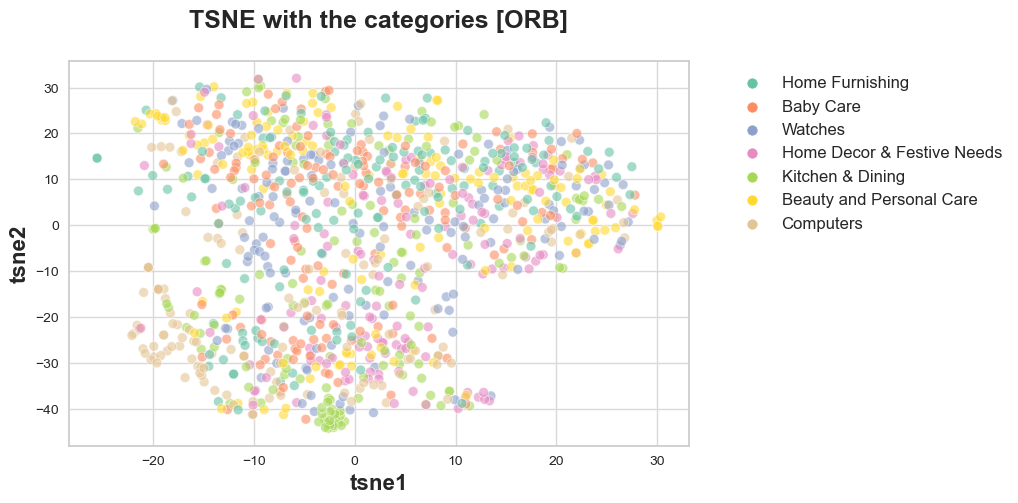

In [98]:
utils.display_tsne_categories(df_tsne, data['category'], 'ORB')

We see from this scatterplot that data has been poorly clustered, different categories are spread all over the plot. We can see however local agglomeration of points of the same category, for example 'Kitchen & Dining' (light green), 'Computers' (brown)

## Clustering

ARI :  0.0355


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

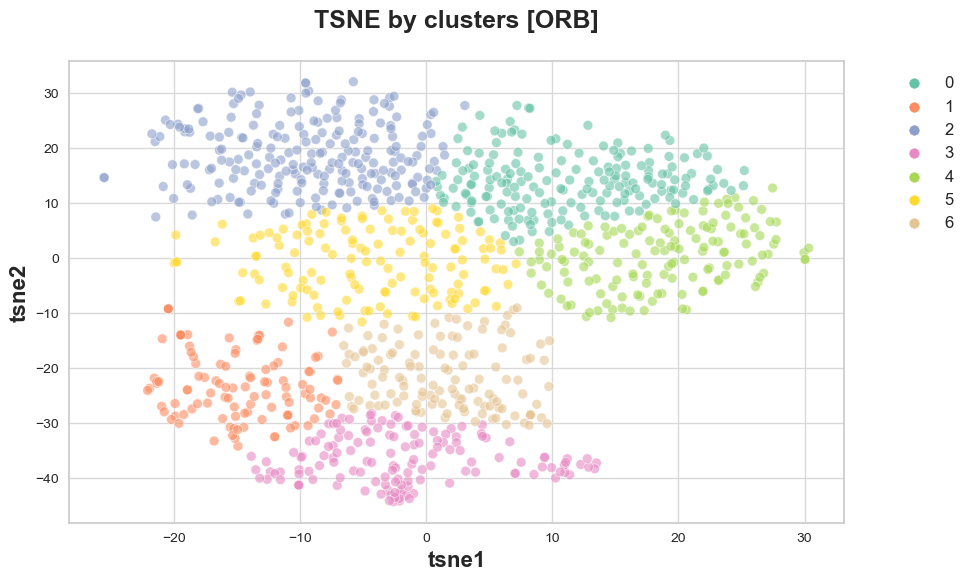

In [99]:
utils.perform_clustering(df_tsne, true_labels = data["category"], method_name='ORB')

After performing the KMeans clustering, the obtained score confirmed the scatterplot, the classification obtained was not successful.

# Test with different number of clusters

As said earlier, there are different strategies in defining the number of clusters of the obtained descriptors, let's try the minimum parameter of number of categories * 10. We will be using the same descriptors array as in the previous step.


In [56]:
start = time.time()

# set number of clusters to the squared root of descriptors length
k_min = len(categories) * 10

# Clustering with batches
kmeans_min = cluster.MiniBatchKMeans(n_clusters=k_min, init_size=3*k, random_state=0, n_init=10)
kmeans_min.fit(orb_descriptors_all)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

execution time: 0.6115 seconds


Create a histogram vectore for each image

In [57]:
start = time.time()

hist_vectors_min = []

for i, image_desc in enumerate(orb_descriptors_array) :
    
    hist = build_histogram(kmeans_min, image_desc, i) #calculates the histogram
    hist_vectors_min.append(hist) #histogram is the feature vector

X_features_min = np.asarray(hist_vectors_min)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')


execution time: 0.2652 seconds


In [116]:
X_features_min_pca = utils.get_pca_reduced_data(X_features_min)

Dimensions before PCA :  (1050, 70)
Dimensions after PCA :  (1050, 63)


In [117]:
df_tsne_min = utils.get_tsne_reduced_dataframe(X_features_min_pca)
df_tsne_min.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

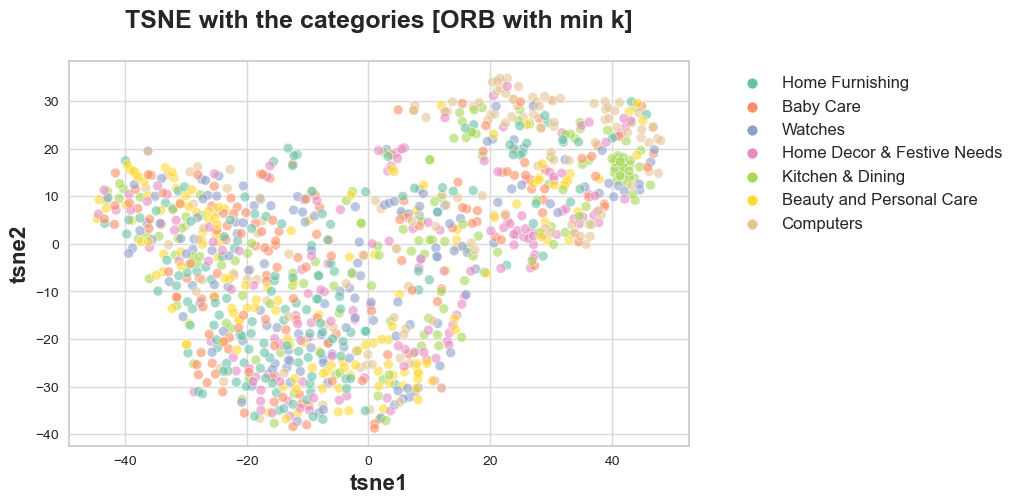

In [118]:
utils.display_tsne_categories(df_tsne_min, data['category'], 'ORB with min k')

From the plot above, we don't observe any improvements comparing to the previous method.

ARI :  0.0323


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

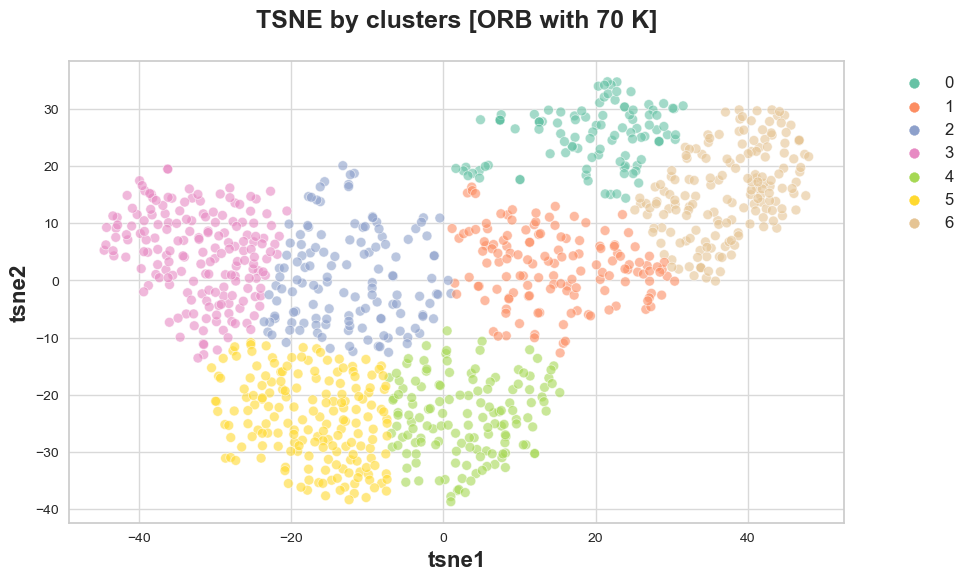

In [119]:
utils.perform_clustering(df_tsne_min, true_labels = data["category"], method_name='ORB with 70 K')

We get an even lower ARI score with a minimum number of clusters.

# Test with SIFT

Scale-Invariant Feature Transform (SIFT).

SIFT can be broken down into two parts: key-point detection and key-point descriptor extraction.

The key-point detection works by approximating Laplacian of Gaussian, which solves the scale variance problem but is expensive to compute, with Difference of Gaussian (DoG). The DoG is stack and searched for local extrema in a 3x3x3 neighborhood to be identified as key-points. To generate the descriptor, a 16x16 neighborhood around the key-point is taken and divided into 4x4 cells. An orientation histogram is calculated for each cell and the combined histograms are concatenated into a 128 dimension feature descriptor.

Try out the SIFT descriptors detection

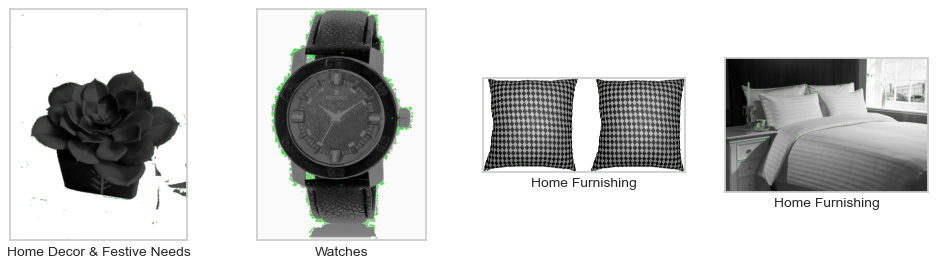

In [121]:
sift = cv2.SIFT_create(500)

def get_image_with_keypoints_sift(image, verbose = True):
    """
    Calculate the keypoints for the image with the SIFT method
    
    Input:
        image: image matrix

    Output:
        image with keypoints
    """

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if verbose:
        print("Number of Keypoints Detected In The Image: ", len(keypoints))
        print("Number of Descriptors Detected In The Image: ", descriptors.shape)
    
    return cv2.drawKeypoints(image, keypoints, image, color = (0, 255, 0))


test_images_eq_with_keypoints_sift = test_images_eq.apply(lambda x: get_image_with_keypoints_sift(x, verbose=False))
display_images(X=list(test_images_eq_with_keypoints_sift), y=list(test_samples['category']),  columns=4, x_size=2, y_size=2)


We don't notice a huge difference in the ORB vs SIFT keypoint detection, the results are quite similar.


Now let's apply the keypoint detection function to all the images.

In [122]:
# Preprocess images
start=time.time()

sift_descriptors = []
sift = cv2.SIFT_create(500)

images_raw_gray = list(data['image_raw_gray'])

for image in images_raw_gray :
    # equalize image histogram
    image = cv2.equalizeHist(image)

    # compute keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    sift_descriptors.append(descriptors)

# convert descriptors to array
sift_descriptors_array = np.asarray(sift_descriptors, dtype="object")
sift_descriptors_all = np.concatenate(sift_descriptors_array, axis=0)

print()
print("Number of descriptors : ", sift_descriptors_all.shape)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')


Number of descriptors :  (517221, 128)
execution time: 176.8508 seconds


We obtained a slightly lower number of descriptors than with ORB, but SIFT took much more time compared to ORB (24 seconds)

**Cluster descriptors**

As in the previous part, let's perform a clustering of obtained descriptors.

In [126]:
start = time.time()

# set number of clusters to the squared root of descriptors length
k_sift = int(round(np.sqrt(len(sift_descriptors_all)), 0))
print("Number of estimated clusters : ", k_sift)

# Clustering with batches
kmeans_sift = cluster.MiniBatchKMeans(n_clusters=k_sift, init_size=3*k, random_state=0, n_init=10)
kmeans_sift.fit(sift_descriptors_all)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

Number of estimated clusters :  719
execution time: 6.3669 seconds


**Create features**

In [127]:
start = time.time()

# Creation of a matrix of histograms
hist_vectors_sift = []

for i, image_desc in enumerate(sift_descriptors_array) :
    
    hist = build_histogram(kmeans_sift, image_desc, i) #calculates the histogram
    hist_vectors_sift.append(hist) #histogram is the feature vector

X_features_sift = np.asarray(hist_vectors_sift)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

execution time: 1.0448 seconds


**Reduce dimensions**

In [128]:
X_features_pca_sift = utils.get_pca_reduced_data(X_features_sift)

Dimensions before PCA :  (1050, 719)
Dimensions after PCA :  (1050, 496)


In [129]:
df_tsne_sift = utils.get_tsne_reduced_dataframe(X_features_pca_sift)
df_tsne_sift.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

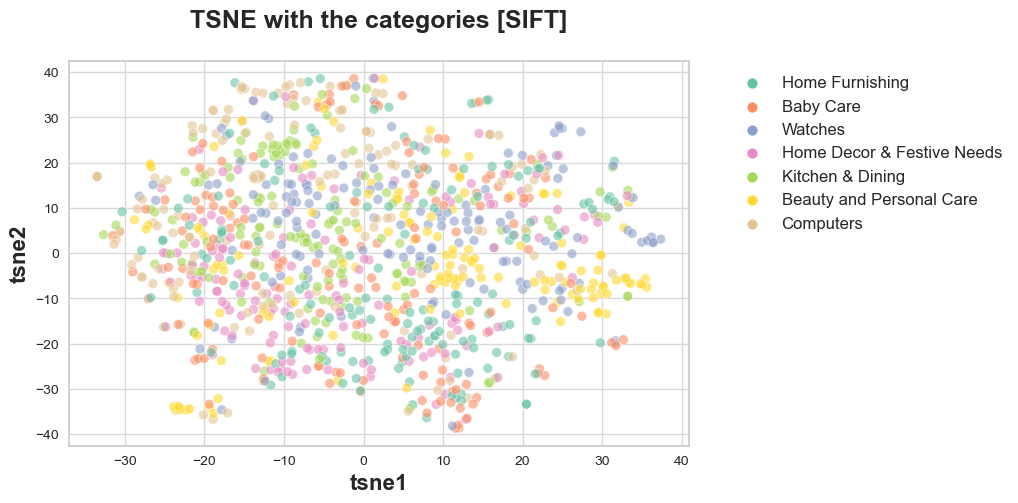

In [130]:
utils.display_tsne_categories(df_tsne_sift, data['category'], 'SIFT')

The resulting plot is also very mixed up, but we tend to see more agglomerations of points of the same categories, especially for the 'Beauty and Personal Care' category (yellow), 'Watches' (blue).

**Clustering**

ARI :  0.0449


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

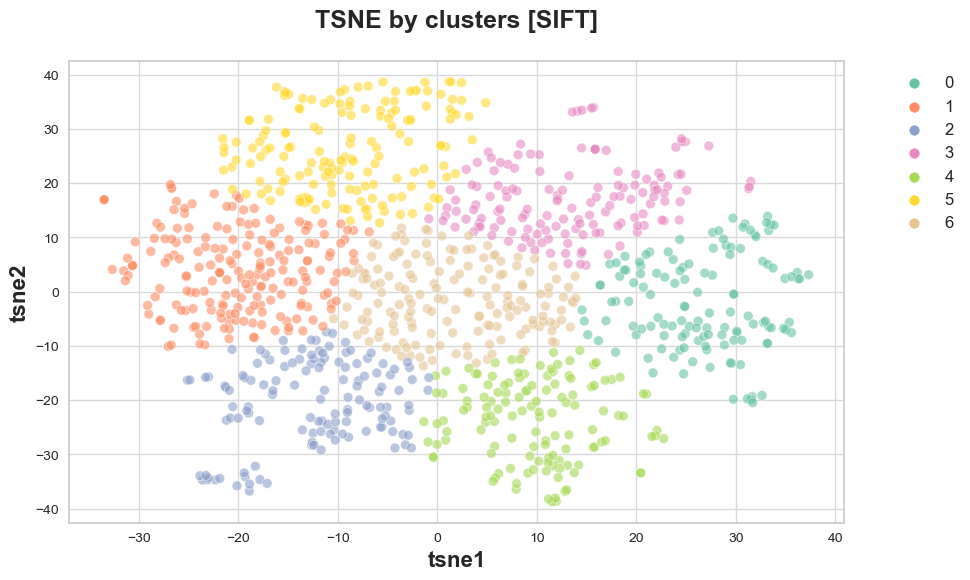

In [131]:
utils.perform_clustering(df_tsne_sift, true_labels=data['category'], method_name='SIFT')

The resulting ARI score is slightly better than the one obtained with ORB, but it is still too low to consider the classification as successfull.

# CNN

**Transfer learning**

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. The transfer learning is used to customize the model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

## VGG16

VGG16 is a convolutional neural network model used for image recognition. Instead of having a large number of hyper-parameters, VGG16 uses convolution layers with a 3x3 filter and a stride 1 that are in the same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has two fully connected layers, followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. 

### Create the model

with the following parameters:
- `include_top`: False => whether to include the 3 fully-connected layers at the top of the network. These layers are connected to the output of the convolutional base, they have a fixed number of nodes with the option to instantiate them with weights pretrained on imagenet. When instantiating a VGG model with the top layers included, the size of the architecture is therefore fixed, and the model will only accept images with a fixed input size of (224,224,3). Feeding the network with images of other sizes would change the amount of weights in the dense classification layers. Excluding the top layers enables us to provide images of different size to the network, and the output of the convolutional stack will change accordingly. These layers are responsible for the classification task and setting `include_top` to False will allow to use the model for feature extraction.
  
- `weights`: 'imagenet' (pre-training on ImageNet)

- `input_shape`: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

- `pooling`: 'max', optional pooling mode for feature extraction when include_top is False. max means that global max pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor

**Read-only mode**

**Read-only** mode in Keras is a feature that allows to freeze the weights of the model during training. This is particularly useful for Transfer Learning, when we want to use a pre-trained model and fine-tune it on a specific task without altering the original weights. By freezing the weights of the initial layers, we can leverage the learned features without overfitting the model. Moreover, freezing layers can make the training process more efficient because there is no backpropagation through all the layers. And finally, it gives more control over which parts of the model are being updated and how.




In [134]:
IMGSIZE = 224

base_vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMGSIZE, IMGSIZE, 3), pooling='max')

# Freeze existing VGG already trained weights
for layer in base_vgg16_model.layers:
    layer.trainable = False

vgg16_model = Model(inputs=base_vgg16_model.inputs, outputs=base_vgg16_model.output)

vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

The layers from the input layer to the last max pooling layer (labeled by 7 x 7 x 512) are regarded as feature extraction part of the model.

Explaining the layers and parameters:

1. Input Layer - (224, 224, 3): initial image size (lx, ly, lz)
2. 1st Convolution Layer - (224, 224, 64): produces 64 layers with a 3x3 kernel with padding so the image size is preserved (224x224), stride 1,  which gives us: (kernel_height * kernel_width * input_channels + 1 (for bias)) * number_of_filters = (3 * 3 * 3 + 1) * 64 = 1792
3. 2nd Convolution Layer - (224, 224, 64): same as previous but with a different number of input channels obtained from the previous layer, that gives us (3 * 3 * 64 + 1) * 64 = 36928
4. Max Pooling Layer - (112, 112, 64): downsample the image along its width and height by the size of the pooling window (2x2) with stride 2x2, so it reduces by 2 the image width and height

These steps - conv2d layers followed by max pooling layer are repeated 4 more times and at the end the images are reduced by 7x. The last layer - global_max_pooling2d comes from the `pooling` parameter in order to get the result in 2 dimensions array instead of 4

### Extract features

As in the previous methods, the idea is to extract features for every image

In [135]:
X_features_vgg16 = []

start = time.time()

for image_file in data['image'] :
    image = load_img(images_path + '/' + image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = vgg16.preprocess_input(image)
    X_features_vgg16.append(vgg16_model.predict(image, verbose=0)[0]) # predict from pretrained model

X_features_vgg16 = np.asarray(X_features_vgg16)
print(f'shape {X_features_vgg16.shape}')

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


shape (1050, 512)
execution time: 99.1465 seconds


### Reduce dimensions

In [136]:
pca_features_vgg16 = utils.get_pca_reduced_data(X_features_vgg16)

Dimensions before PCA :  (1050, 512)
Dimensions after PCA :  (1050, 401)


In [137]:
df_tsne_vgg16 = utils.get_tsne_reduced_dataframe(pca_features_vgg16)
df_tsne_vgg16.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

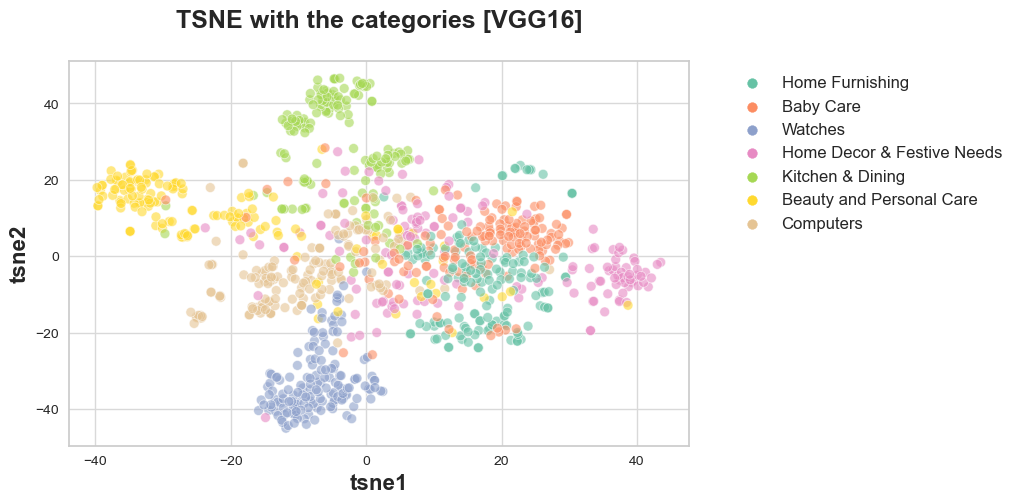

In [138]:
utils.display_tsne_categories(df_tsne_vgg16, data['category'], 'VGG16')

We can observe from the plot above that most of the categories were correctly identified, however VGG16 seems to have some trouble with distinguishing 'Home Furnishing', 'Home Decor and Festive Needs' and 'Baby Care' categories

### Clustering

ARI :  0.4265


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

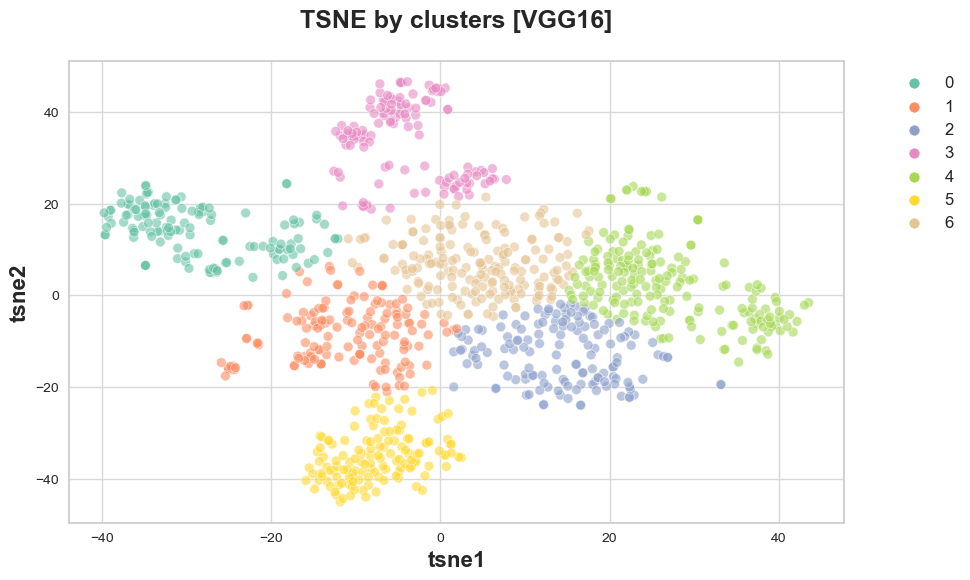

In [139]:
utils.perform_clustering(df_tsne_vgg16, true_labels=data['category'], method_name='VGG16')

The image classification worked well with an ARI score of 0.43

## ResNet50

ResNet (Residual Network) is a type of CNN, it is composed of 50 layers (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

The 50-layer ResNet architecture includes the following elements:

- A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.
- A max pooling layer with a 2-sized stride.
- 9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times. 
- 12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.
- 18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.
- 9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.

Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.

### Create the model

We will follow the same process as for VGG16 model and provide the same parameters to ResNet50:
- `weights`: 'imagenet' to use already pretrained weights
- `include_top`: False to include only convolution layers for the feature extraction
- `input_shape`: (224, 224, 3)
- `pooling`: 'avg' to get 2D array at the output

In [140]:
IMGSIZE = 224

base_resnet_model = ResNet50(weights = 'imagenet', include_top = False, input_shape=(IMGSIZE, IMGSIZE, 3), pooling='avg')

# Freeze existing ResNet already trained weights
for layer in base_resnet_model.layers:
    layer.trainable = False

resnet_model = Model(inputs=base_resnet_model.inputs, outputs=base_resnet_model.output)

resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Extract features

In [141]:
X_features_resnet = []

start = time.time()

for image_file in data['image'] :
    image = load_img(images_path + '/' + image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = resnet50.preprocess_input(image)
    X_features_resnet.append(resnet_model.predict(image, verbose=0)[0])

X_features_resnet = np.asarray(X_features_resnet)
print(f'shape {X_features_resnet.shape}')

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


shape (1050, 2048)
execution time: 65.1793 seconds


### Reduce dimensions

In [142]:
pca_features_resnet = utils.get_pca_reduced_data(X_features_resnet)

Dimensions before PCA :  (1050, 2048)
Dimensions after PCA :  (1050, 722)


In [143]:
df_tsne_resnet = utils.get_tsne_reduced_dataframe(pca_features_resnet)
df_tsne_resnet.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

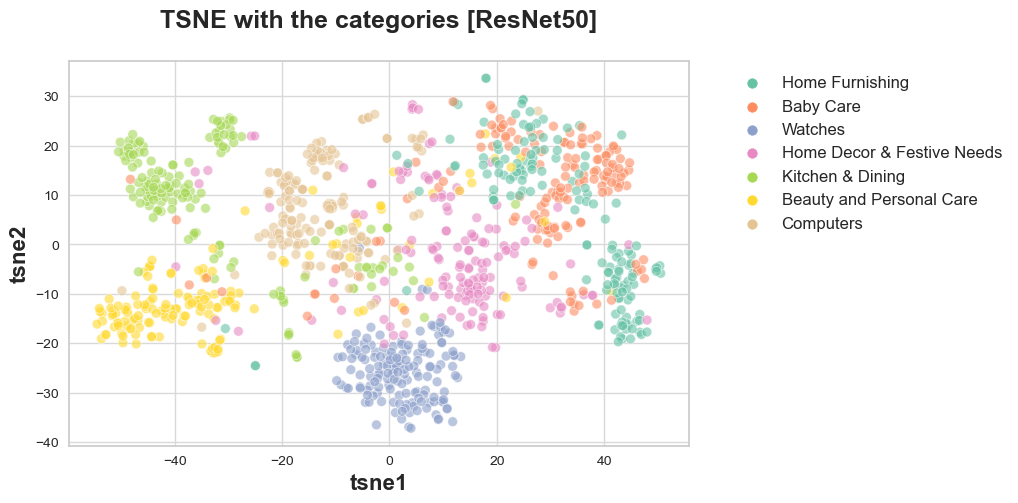

In [144]:
utils.display_tsne_categories(df_tsne_resnet, data['category'], 'ResNet50')

The separation in clusters looks better than with VGG16, the same categories are mixed up however but in lesser extent.

### Clustering

ARI :  0.5503


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

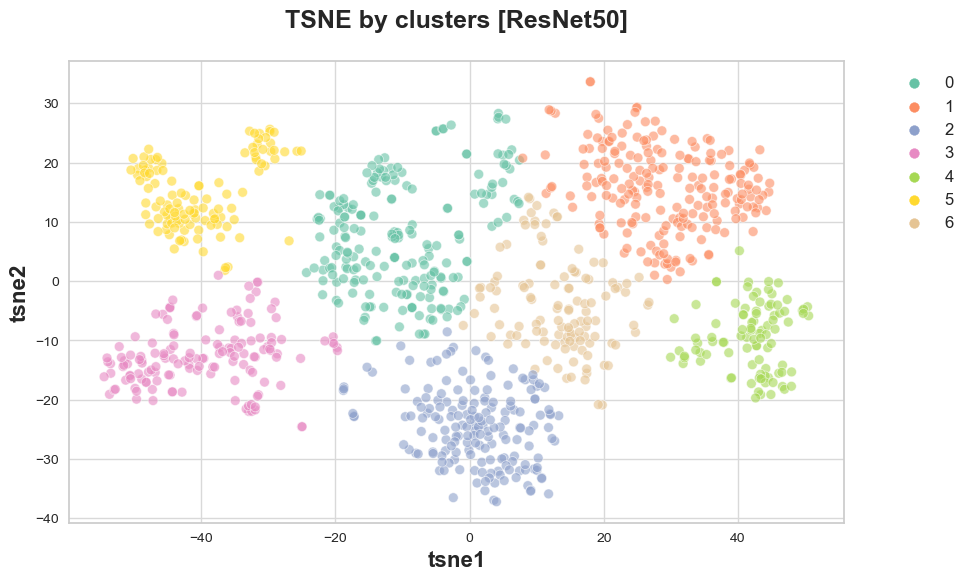

In [145]:
utils.perform_clustering(df_tsne_resnet, true_labels=data['category'], method_name='ResNet50')

The ResNet50 model performed better than VGG16 with 0.55 ARI score and it took less time (69 seconds vs 99 seconds in VGG16)

# Experiment with Image + Text features

We will use features extracted with USE for the text data and features provided by ResNet50 for the image. The idea is to concatenate the 2 vectors and perform the dimensiality reduction + clustering to see if we obtain better results by combining image and text data

## Concatenate features

In [81]:
# load numpy array for the text features
X_features_use = np.load('./features/features_use.npy')
print(X_features_use.shape)
X_features_use

(1050, 512)


array([[-0.05110104, -0.05144482,  0.01383961, ...,  0.04022034,
         0.048516  ,  0.0158398 ],
       [-0.04389047, -0.00195715, -0.02649419, ...,  0.03154325,
         0.05372116,  0.02607659],
       [-0.05426852, -0.02994479, -0.03851028, ...,  0.03896609,
         0.00296324, -0.0245343 ],
       ...,
       [ 0.04087017,  0.04559577,  0.05973959, ..., -0.05486848,
         0.06035574, -0.06444691],
       [ 0.0117093 ,  0.03432317,  0.05904543, ...,  0.00107489,
        -0.04824701, -0.04341351],
       [-0.03311532,  0.05699969,  0.06610578, ...,  0.02565977,
        -0.05126197, -0.04026143]], dtype=float32)

In [82]:
X_features_resnet.shape

(1050, 2048)

Concatenate the 2 arrays, the resulting array should be of shape (1050, 2560)

In [83]:
X_features_common = np.concatenate((X_features_use, X_features_resnet), axis=1)
X_features_common.shape

(1050, 2560)

## Reduce dimensions

In [146]:
pca_features_common = utils.get_pca_reduced_data(X_features_common)

Dimensions before PCA :  (1050, 2560)
Dimensions after PCA :  (1050, 724)


In [147]:
df_tsne_common = utils.get_tsne_reduced_dataframe(pca_features_common)
df_tsne_common.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

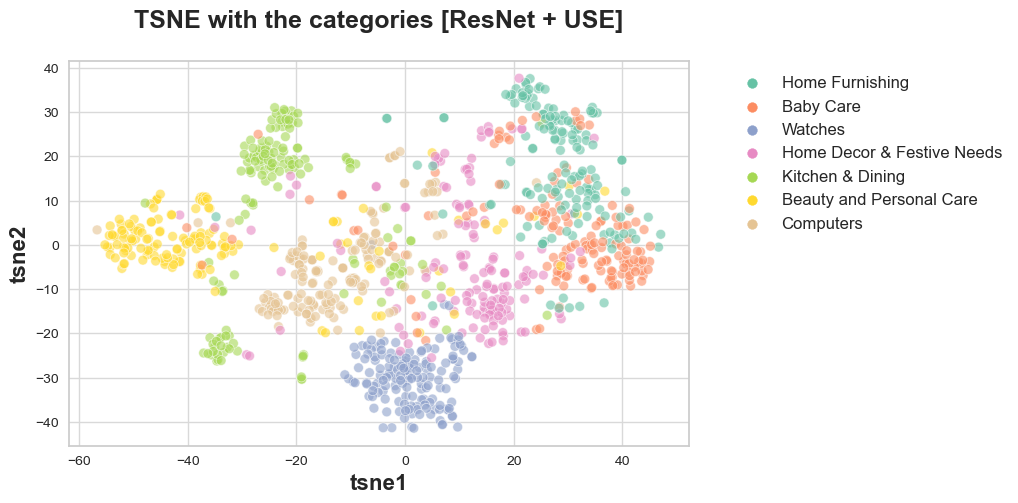

In [148]:
utils.display_tsne_categories(df_tsne_common, data['category'], 'ResNet + USE')

The resulting clustering seems less successful than the one obtained with USE or ResNet50.

## Clustering

ARI :  0.4649


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

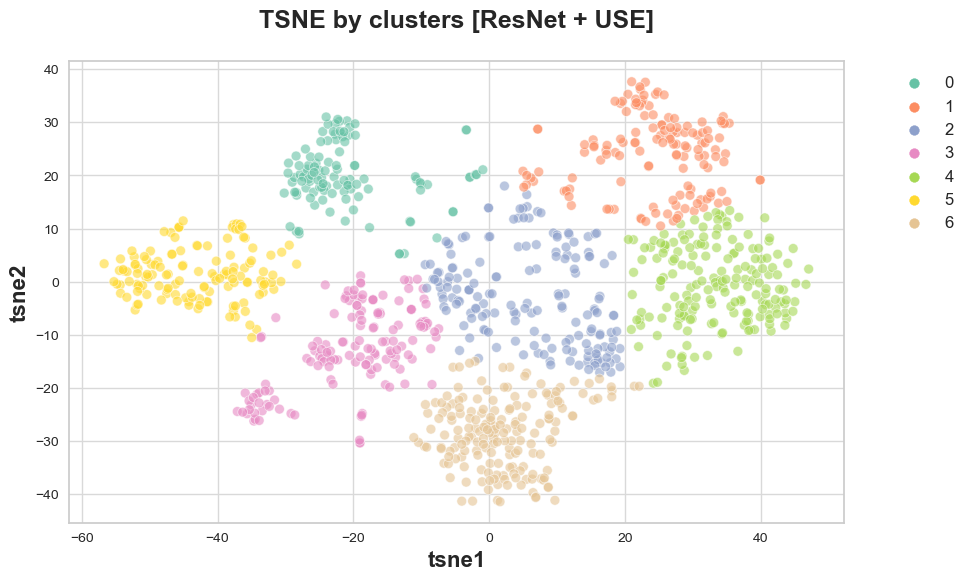

In [149]:
utils.perform_clustering(df_tsne_common, true_labels=data['category'], method_name='ResNet + USE')

The resulting ARI score confirms the graphic analysis, it is less interesting than the one obtained by doing separately image or text feature clustering. It might be explained by the scaling issue, as the values obtained in text and image feature vectors are of different scales. It might be interesting to pursue this experiment by performing a scaling of the concatenated feature vector but it is out of the scope of this project.

# Conclusion

To sum up, different preprocessing and feature extraction techniques have been tested, like ORB, SIFT and transfer learning.

ORB and SIFT didn't perform well with the given dataset, the convolutional networks gave better results:

- VGG16: 0.43 ARI score
- ResNet50: 0.55 ARI score

It might be explained by the fact that CNNs were already trained on a large image dataset (Imagenet) that facilitated a lot the feature extraction on the product images.

Finally, text and image feature extraction were combined together but gave lower scores than applying both techniques separately that might be due to the scaling problem.